# Toxic Comment Classification Challenge
# Selected Model Evaluation

## Introduction

In this notebook, we perform a evaluation of the final selected model, which was chosen based on its superior performance in multi-label classification tasks. The evaluation process includes testing the model on unseen test data and fine-tuning thresholds for each toxicity label to optimize its precision and recall. We will also analyze key performance metrics such as accuracy, F1 score, precision, and recall for each label to assess the model's ability to generalize to new data.

### Environment and Data Setup

In [1]:
import os
import sys

sys.path.append('../')

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from utils import MultiLabelDataset
from utils import compare_datasets
from utils import CustomDataset
from utils import Main_Model_Multihead
from utils import run_evaluation_and_threshold_optimization

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MiestoMeska\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MiestoMeska\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train_data = pd.read_csv('../data/augmented_data.csv')

In [3]:
train_data.drop(['id'], inplace=True, axis=1)
train_data['is_toxic'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
binary_label_column = 'is_toxic'
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### Data Splitting using Stratification

In this section, we split the dataset into training, validation, and test sets using StratifiedShuffleSplit to ensure the same proportion of toxic and non-toxic samples across all splits. Stratification helps maintain the class distribution in each subset, which is crucial when dealing with imbalanced datasets like the one used for toxic comment classification.

The initial dataset is split into a training set (70%), a validation set (15%), and a test set (15%). To further balance the training set, the non-toxic samples are undersampled to match the number of toxic samples, ensuring an equal representation of both classes during training. This approach aims to prevent the model from being biased toward the majority class (non-toxic) and improves its ability to detect toxic comments.

In [4]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=123)

for train_idx, temp_idx in strat_split.split(train_data, train_data['is_toxic']):
    train_df = train_data.iloc[train_idx]
    temp_df = train_data.iloc[temp_idx]

val_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=123)

for val_idx, test_idx in val_test_split.split(temp_df, temp_df['is_toxic']):
    val_df = temp_df.iloc[val_idx]
    test_df = temp_df.iloc[test_idx]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Training Dataset: {train_df.shape}")
print(f"Validation Dataset: {val_df.shape}")
print(f"Test Dataset: {test_df.shape}")

Training Dataset: (113140, 8)
Validation Dataset: (24244, 8)
Test Dataset: (24245, 8)


In [5]:
toxic_df = train_df[train_df['is_toxic'] == 1]
non_toxic_df = train_df[train_df['is_toxic'] == 0]

undersampled_non_toxic_df = resample(non_toxic_df,
                                     replace=False,
                                     n_samples=len(toxic_df),
                                     random_state=123)

undersampled_train_df = pd.concat([toxic_df, undersampled_non_toxic_df])

undersampled_train_df = undersampled_train_df.sample(frac=1, random_state=123).reset_index(drop=True)

print(f"Original Training Set Shape: {train_df.shape}")
print(f"Undersampled Training Set Shape: {undersampled_train_df.shape}")

Original Training Set Shape: (113140, 8)
Undersampled Training Set Shape: (27580, 8)


### Calculating the Class Weights

In [6]:
binary_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=undersampled_train_df['is_toxic']
)

binary_weights_tensor = torch.tensor(binary_class_weights, dtype=torch.float32)
print("Binary Class Weights (Toxic vs Non-Toxic):", binary_weights_tensor)

toxic_samples = undersampled_train_df[undersampled_train_df['is_toxic'] == 1]

multilabel_class_weights = {}
for label in label_columns:
    multilabel_class_weights[label] = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=undersampled_train_df[label]
    )

class_weights_tensor = torch.tensor(
    [multilabel_class_weights[label][1] for label in label_columns], dtype=torch.float32
)
print("Multilabel Class Weights:", class_weights_tensor)

Binary Class Weights (Toxic vs Non-Toxic): tensor([1., 1.])
Multilabel Class Weights: tensor([ 1.0575,  5.9491,  1.7576, 11.3126,  1.8607,  6.7532])


### Creating Data Loaders

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
logger = TensorBoardLogger("tb_logs", name="multihead_model_shared_wloss")

hparams = {
    'learning_rate': 1e-4,
    'batch_size': 16,
    'gradient_accumulation_steps': 16
}

max_len = 192
num_workers=10

text_column = 'cleaned_text'
binary_label_column = 'is_toxic'

train_dataset = CustomDataset(undersampled_train_df, tokenizer, max_len, label_columns, binary_label_column, text_column)
val_dataset = CustomDataset(val_df, tokenizer, max_len, label_columns, binary_label_column, text_column)
test_dataset = CustomDataset(test_df, tokenizer, max_len, label_columns, binary_label_column, text_column)

train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=False, num_workers=num_workers, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, num_workers=num_workers, persistent_workers=True)


C:\Users\MiestoMeska\anaconda3\envs\TC_4\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Loading the Model

In [8]:
best_multihead_model_path = '../models/multihead/multihead_best_multilabel-v4.ckpt'
checkpoint = torch.load(best_multihead_model_path)

state_dict = checkpoint['state_dict']

C:\Users\MiestoMeska\AppData\Local\Temp\ipykernel_16816\99823090.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_multihead_model_path)


In [9]:
new_state_dict = {}
for key in state_dict:
    new_key = key.replace('model.', '')
    new_state_dict[new_key] = state_dict[key]

### Architecture of the Model

In [10]:
multihead_model = Main_Model_Multihead(
    freeze_base=True,
    num_labels=6,
    learning_rate=1e-5,
    class_weights=class_weights_tensor,
    binary_weights=binary_weights_tensor[1:]
)

multihead_model.load_state_dict(new_state_dict)

multihead_model.eval()

Main_Model_Multihead(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

The Main_Model_Multihead is a multi-label classification model based on the DistilBERT architecture. It incorporates multiple classification heads, each responsible for predicting a specific type of toxicity.

The model consists of:

* DistilBERT base for extracting contextual embeddings from text.
* Separate classifier heads (each with multiple linear layers, ReLU activations, and dropout for regularization) for each toxicity category. These heads enable independent learning for each label.
* Binary classification head for overall toxicity detection.

## Evaluation of the Model

In this section, we evaluate the performance of the final Main_Model_Multihead on the test dataset. The test data is passed through the model, and a detailed analysis is conducted for each toxicity label. This includes generating confusion matrices for each class to visualize the model's predictions and assess its classification capabilities. Key metrics such as accuracy, precision, recall, and F1 score are printed to evaluate the model's performance.

After the initial evaluation, optimal thresholds are calculated for each toxicity label to improve the balance between precision and recall. These thresholds are applied to the model predictions, and the evaluation is repeated. The confusion matrices and metrics are re-calculated to assess how the optimized thresholds affect the model's classification accuracy and ability to correctly identify toxic comments.

Running inference for probabilities: 100%|█████████████████████████████████████████| 1516/1516 [01:59<00:00, 12.63it/s]


Initial Evaluation with Default Thresholds (0.5 for all):

Evaluating Binary Classification (Toxic vs Non-Toxic)
Binary Confusion Matrix:
[[19160  2130]
 [  277  2678]]
Precision: 0.5570, Recall: 0.9063, F1-Score: 0.6899

Evaluating Multilabel Classification (Toxicity Classes)

Confusion Matrix for toxic:
[[20115  1361]
 [  397  2372]]
Precision: 0.6354, Recall: 0.8566, F1-Score: 0.7296

Confusion Matrix for severe_toxic:
[[23337   426]
 [  129   353]]
Precision: 0.4531, Recall: 0.7324, F1-Score: 0.5599

Confusion Matrix for obscene:
[[22185   399]
 [  410  1251]]
Precision: 0.7582, Recall: 0.7532, F1-Score: 0.7557

Confusion Matrix for threat:
[[23775   193]
 [   37   240]]
Precision: 0.5543, Recall: 0.8664, F1-Score: 0.6761

Confusion Matrix for insult:
[[22152   523]
 [  432  1138]]
Precision: 0.6851, Recall: 0.7248, F1-Score: 0.7044

Confusion Matrix for identity_hate:
[[23432   374]
 [  118   321]]
Precision: 0.4619, Recall: 0.7312, F1-Score: 0.5661

Optimizing Thresholds...

Opti

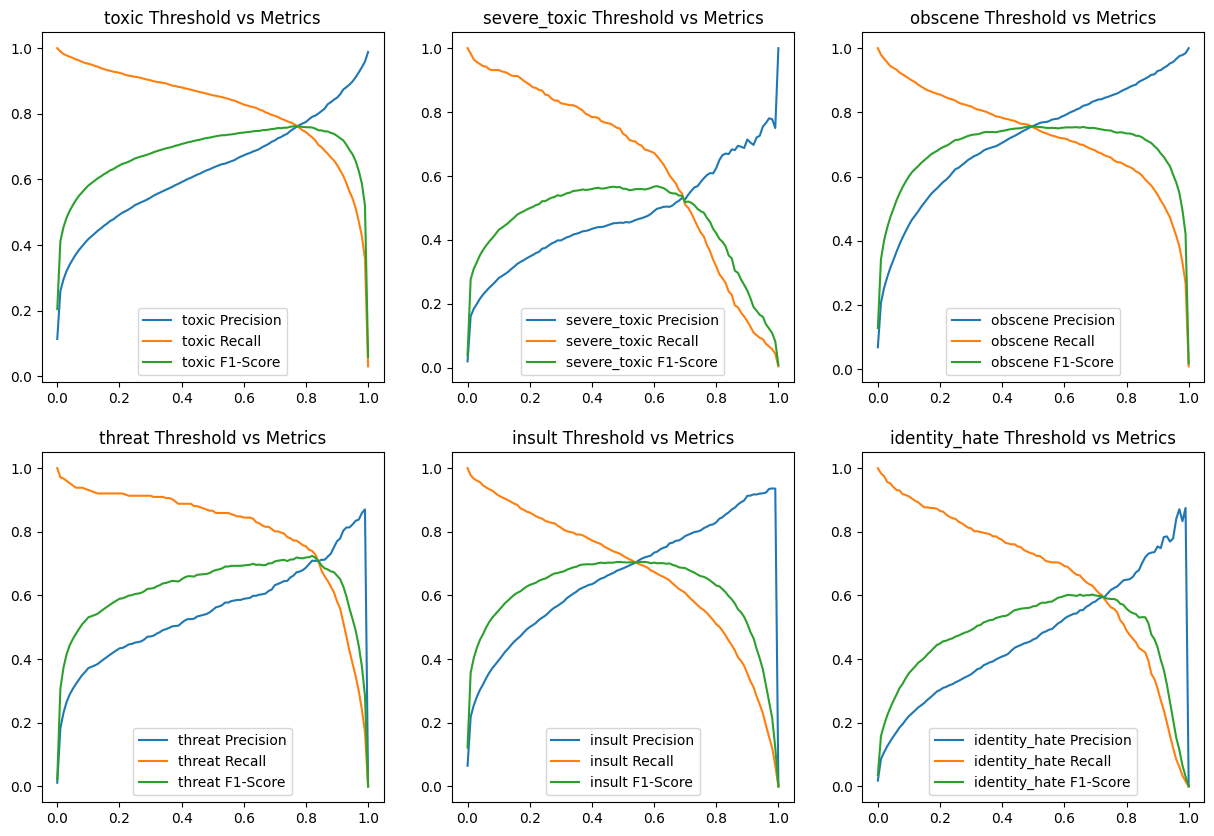

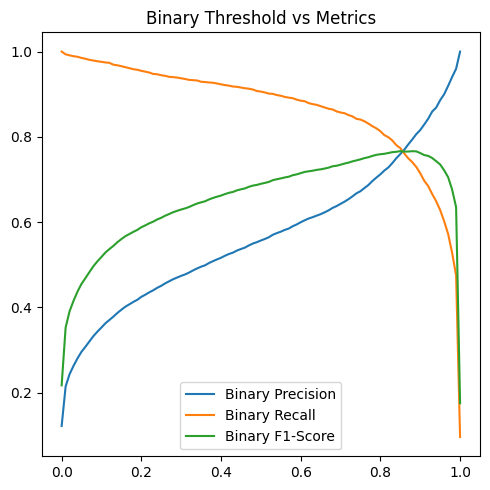


Plotting ROC Curves...


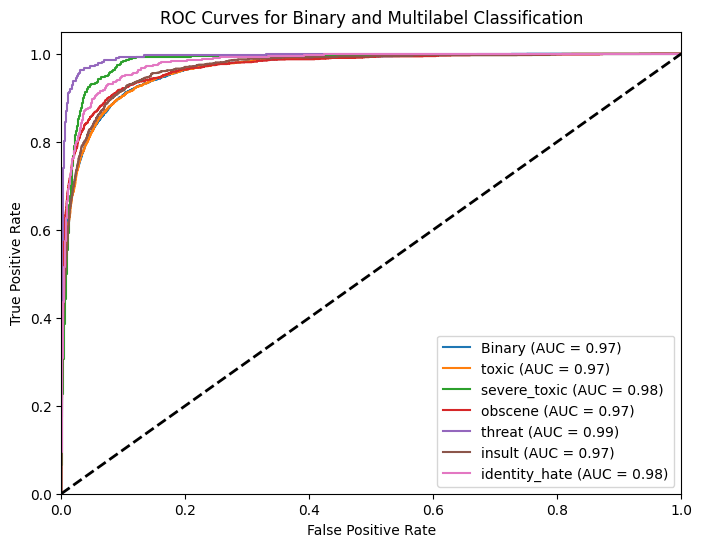


Setting optimized thresholds in the model...

Re-running predictions with optimized thresholds...


Running inference for probabilities: 100%|█████████████████████████████████████████| 1516/1516 [01:00<00:00, 25.13it/s]



Re-Evaluation with Optimized Thresholds:

Evaluating Binary Classification (Toxic vs Non-Toxic)
Binary Confusion Matrix:
[[20567   723]
 [  669  2286]]
Precision: 0.7597, Recall: 0.7736, F1-Score: 0.7666

Evaluating Multilabel Classification (Toxicity Classes)

Confusion Matrix for toxic:
[[20808   668]
 [  653  2116]]
Precision: 0.7601, Recall: 0.7642, F1-Score: 0.7621

Confusion Matrix for severe_toxic:
[[23441   322]
 [  163   319]]
Precision: 0.4977, Recall: 0.6618, F1-Score: 0.5681

Confusion Matrix for obscene:
[[22173   411]
 [  401  1260]]
Precision: 0.7540, Recall: 0.7586, F1-Score: 0.7563

Confusion Matrix for threat:
[[23884    84]
 [   72   205]]
Precision: 0.7093, Recall: 0.7401, F1-Score: 0.7244

Confusion Matrix for insult:
[[22241   434]
 [  478  1092]]
Precision: 0.7156, Recall: 0.6955, F1-Score: 0.7054

Confusion Matrix for identity_hate:
[[23571   235]
 [  148   291]]
Precision: 0.5532, Recall: 0.6629, F1-Score: 0.6031


In [11]:
run_evaluation_and_threshold_optimization(multihead_model, test_loader, device='cuda')

The model evaluation shows promising performance for both binary classification (toxic vs. non-toxic) and multi-label classification (six toxicity categories) after threshold optimization. Here are the key conclusions:

**Binary Classification:**

After threshold optimization, the binary classifier achieved an F1-Score of 0.7666, with a precision of 0.7597 and a recall of 0.7736.
The confusion matrix reveals a significant reduction in false positives after threshold adjustment, indicating a better balance between precision and recall compared to the initial evaluation. This improves the model's ability to correctly classify toxic vs. non-toxic comments.

**Multi-Label Classification:**

* Toxic: The optimized threshold improved the F1-score to 0.7621, balancing precision and recall (both above 0.76). The model performed consistently across most common toxic comments.

* Severe Toxic: Although there was some improvement, the F1-score remained at 0.5681, indicating that this class remains challenging due to fewer training samples. Precision improved, but recall is still moderate.

* Obscene: With an F1-score of 0.7563, the model showed high accuracy for obscene content, with precision and recall both close to 0.75.

* Threat: The optimized threshold significantly improved precision and recall balance, with an F1-score of 0.7244, making it a strong predictor for threat classification.

* Insult: A slight improvement resulted in an F1-score of 0.7054, with a reasonable balance between precision and recall.

* Identity Hate: This category saw the most improvement with a final F1-score of 0.6031, reflecting better handling of this underrepresented class.
Threshold Optimization:

The threshold optimization had a notable impact on performance across all labels, with substantial improvements in precision for most classes. The model now strikes a better balance between correctly identifying toxic content and minimizing false positives, especially in binary classification and common toxic labels like "toxic" and "obscene."

**ROC-AUC Performance:**

The ROC curves indicate a strong overall performance across all labels, with AUC values ranging from 0.97 to 0.99, reflecting the model's capability to distinguish between classes accurately.

**Overall Conclusions:**

* The Main_Model_Multihead shows robust performance in binary classification and multi-label classification, particularly after applying optimized thresholds. The model is well-suited for identifying more common toxic categories such as "toxic," "obscene," and "insult."

* However, underrepresented classes like "severe toxic" and "identity hate" still pose challenges, and future efforts could focus on additional data augmentation or further experimentation with model architectures to improve performance on these classes.

* Overall, the model's balanced precision and recall indicate it can effectively support content moderation tasks by accurately flagging toxic content across multiple categories, with the optimized thresholds improving real-world applicability.